In [1]:
import pandas as pd
import numpy as np
import os
import h5py
from copy import deepcopy
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
import seaborn as sns

from utils_plot import *

cm = 1/2.54 
h=5.8*1.1
w=6*1.1

resp_res_path = '/cluster/work/grlab/clinical/hirid2/research/event_based_analysis/resp/'
renal_res_path = '/cluster/work/grlab/clinical/hirid2/research/kdigo_analysis/'
resp_fig_path = '../Figures_Resp'
renal_fig_path = 'paper_figures_renal'

In [2]:
# early warning system configuration
renal_ews_configs = dict()
renal_ews_configs.update(pred_win=2880)
renal_ews_configs.update(min_event_gap=0)
renal_ews_configs.update(t_silence=480)
renal_ews_configs.update(t_buffer=0)
renal_ews_configs.update(t_reset=720)

splits = ['temporal_%d'%i for i in np.arange(1,6)]
calibration = True

In [3]:
curve_ref = {"ref": dict(res_path=os.path.join(renal_res_path, "var28_simple_features_separate_combined_calibrated_lgbm_test_FromZero"),
                         color='C0',
                         linestyle='-',
                         random_classifier=False,
                         splits=splits)}

for k in curve_ref.keys():
    curve_ref[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*2*cm, h*cm))
_, prev_ref = plot_event_based_prc(curve_ref, fixed_rec=1.0)
plt.close()

In [4]:
curves = dict()

for i, age in enumerate(['age_16_30', 'age_31_45', "age_46_65", "age_66_80", "age_81_100"]):
    curves.update({age: dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_%s_separate_combined_calibrated_lgbm_test_FromZero'%age),
                             color='C0',
                             linestyle='-',
                             random_classifier=False,
                             age=age,
                             splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*2*cm, h*cm))
_, prev = plot_metric_vs_setting(curves,xlabel="age",ylabel="precision", fixed_rec=1)
plt.close()

In [5]:
curves = dict()
for i, age in enumerate(['age_16_30', 'age_31_45', "age_46_65", "age_66_80", "age_81_100"]):
    prev_adj = prev[i]
    calibrated_s = (1/prev_ref-1) / (1/prev_adj-1)
    curves.update({age: dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_%s_separate_combined_calibrated_lgbm_test_FromZero'%age),
                             color='C0',
                             linestyle='-',
                             random_classifier=False,
                             calibration_scaler=calibrated_s if calibration else 1,
                             age=age,
                             splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
curves_gbdt = deepcopy(curves)

In [6]:
curves = dict()
for i, age in enumerate(['age_16_30', 'age_31_45', "age_46_65", "age_66_80", "age_81_100"]):
    prev_adj = prev[i]
    calibrated_s = (1/prev_ref-1) / (1/prev_adj-1)
    curves.update({age: dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_%s_separate_combined_calibrated_lstm_test_FromZero'%age),
                             color='C0',
                             linestyle='-',
                             random_classifier=False,
                             calibration_scaler=calibrated_s if calibration else 1,
                             age=age,
                             splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
curves_lstm = deepcopy(curves)

In [7]:
plt.figure(figsize=(w*2*cm, h*0.5*cm))
metric_gbdt, _ = plot_metric_vs_setting(curves_gbdt,xlabel="age")
metric_lstm, _ = plot_metric_vs_setting(curves_lstm,xlabel="age")
plt.close()

In [8]:
all_metric = []
xticks = [curves_gbdt[model]["age"] for model in curves_gbdt.keys()]
for model, metric in [("Time-stacked GBDT-snapshot", metric_gbdt),
                      ("LSTM", metric_lstm)]:
    metric.loc[:,"Model"] = model    
    all_metric.append(metric)
all_metric = pd.concat(all_metric).reset_index(drop=True)

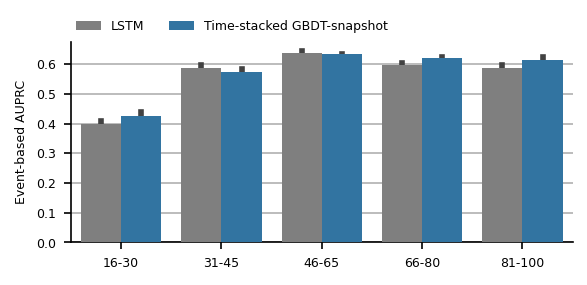

In [9]:
plt.figure(figsize=(w*1.5*cm, h*0.75*cm))
sns.barplot(all_metric, x="age", y="metric", order=xticks,
            hue="Model", hue_order=["LSTM", "Time-stacked GBDT-snapshot"], 
            palette=["C7", "C0"], zorder=10)
plt.xticks(range(len(xticks)), [x.replace("age_","").replace("_","-") for x in xticks])
plt.xlabel("")
plt.ylabel("Event-based AUPRC")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncols=2, borderaxespad=0.)
plt.tight_layout()
plt.grid(axis="y")
plt.savefig(os.path.join(renal_fig_path,'age_fairness_calibrated' if calibration else "age_fairness_uncalibrated"))
plt.show()  